### Best Model

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid

import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

import pickle


In [3]:
# Set the path 
path = 'ML_data.csv'

# Read the dataframe
df = pd.read_csv(path)

# Set opition to display all the columns
pd.set_option('display.max_columns', None)

# Display the first five rows of the dataframe
df.head()

,ethnicity,race,sex,outcome,preapproval,loan_type,reverse_mortgage,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,interest_rate,loan_term,interest_only_payment,property_value,occupancy_type,total_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,age,co_applicant,intermediary,denial_reason
0,Not Hispanic or Latino,White,Joint,1,2,1,2,1,165000.0,75.00,5.75,300.0,2,225000.0,3,4.0,371.0,50%-<60%,3,2,55-64,0,1,10
1,Not Hispanic or Latino,White,Male,1,2,1,2,2,325000.0,79.75,5.75,12.0,1,405000.0,1,1.0,62.0,40%-<50%,1,10,55-64,1,1,10
2,Not Hispanic or Latino,White,Male,1,2,1,2,2,75000.0,62.93,4.75,240.0,2,115000.0,1,1.0,43.0,30%-<40%,3,10,45-54,1,1,10
3,Not Hispanic or Latino,White,Joint,1,2,1,2,2,725000.0,79.98,5.50,360.0,2,905000.0,2,1.0,662.0,<20%,1,1,55-64,0,1,10
4,Not Hispanic or Latino,White,Male,1,2,1,2,1,145000.0,76.92,6.11,300.0,2,185000.0,3,1.0,176.0,<20%,1,10,45-54,1,1,10


In [4]:
# Check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839365 entries, 0 to 4839364
Data columns (total 24 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   ethnicity                       object 
 1   race                            object 
 2   sex                             object 
 3   outcome                         int64  
 4   preapproval                     int64  
 5   loan_type                       int64  
 6   reverse_mortgage                int64  
 7   business_or_commercial_purpose  int64  
 8   loan_amount                     float64
 9   loan_to_value_ratio             float64
 10  interest_rate                   float64
 11  loan_term                       float64
 12  interest_only_payment           int64  
 13  property_value                  float64
 14  occupancy_type                  int64  
 15  total_units                     float64
 16  income                          float64
 17  debt_to_income_ratio       

In [5]:
# Check the dimensions of the dataset
df.shape

(4839365, 24)

In [6]:
df['outcome'].value_counts()

outcome
1    4147252
0     692113
Name: count, dtype: int64

Owing to the massive amount of rows in the dataset and the class imbalance, I will take a sample of the dataset so that the class is balanced at 50-50

### Train-Test-Split

In [9]:
# Take a balanced sample for training
balanced = df.groupby('outcome', group_keys=False).apply(lambda x: x.sample(600000, random_state=42))

/var/folders/md/rprl_jf94cx0vvvnxffb9cn00000gn/T/ipykernel_5637/571252162.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced = df.groupby('outcome', group_keys=False).apply(lambda x: x.sample(600000, random_state=42))


In [10]:

balanced['outcome'].value_counts()

outcome
0    600000
1    600000
Name: count, dtype: int64

In [11]:
# Make a copy of the dataframe
data = balanced.copy()

In [12]:
#Drop unnecessary columns from the DataFrame
data = data.drop(columns = ['ethnicity', 
                             'race',
                             'sex',  
                             'preapproval',  # is an indicator if the mortagage will be approved
                             'loan_type',
                             'reverse_mortgage', 
                             'business_or_commercial_purpose', 
                             #'loan_amount',
                             'loan_to_value_ratio',
                             'interest_rate', # contains too many null values
                             'loan_term',
                             'interest_only_payment', 
                            # 'property_value', 
                             'occupancy_type',
                             'total_units', 
                            # 'income', 
                             #'debt_to_income_ratio',
                             'applicant_credit_score_type', 
                             'co-applicant_credit_score_type', 
                             'age',
                             #'co_applicant', 
                             'intermediary', 
                             'denial_reason'# denial reason is inputed after the application so must be dropped
                           ])

In [13]:
# Convert categorical variables into dummy/indicator variables
data = pd.get_dummies(data, 
                      columns=[#'ethnicity', 
                               #'race', 
                               #'sex',
                               'debt_to_income_ratio', 
                               # 'age'
                      ],
                      drop_first=True, 
                      dtype = int)


In [14]:
data['outcome'].value_counts()

outcome
0    600000
1    600000
Name: count, dtype: int64

In [15]:
# Get the list of column names from the dataset
features = list(data.columns)

# Remove the target variable 'outcome' from the list of features
features.remove('outcome')

# Assign the target variable 'outcome' to y
y = data['outcome']

# Assign the features to X
X = data[features]

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')  # Example imputation strategy (median)

# Fit and transform on training set
X_train_imputed = imputer.fit_transform(X_train)
# Transform the test set using parameters learned from training set
X_test_imputed = imputer.transform(X_test)

# Convert imputed arrays back to DataFrames (optional for convenience)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X.columns)

In [18]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform on training set
X_train_scaled = scaler.fit_transform(X_train_imputed)
# Transform the test set using parameters learned from training set
X_test_scaled = scaler.transform(X_test_imputed)

# Convert scaled arrays back to DataFrames (optional for convenience)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [19]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [20]:
# Check if the indices of the training data X_train and y_train are the same
all(X_train.index == y_train.index)

# Check if the indices of the testing data X_test and y_test are the same
all(X_test.index == y_test.index)

True

### LightGBM

In [22]:
# Initialize and train a LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Fit the model on the imputed and scaled training data
lgb_clf.fit(X_train_scaled, y_train)


[LightGBM] [Info] Number of positive: 480177, number of negative: 479823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500184 -> initscore=0.000738
[LightGBM] [Info] Start training from score 0.000738


LGBMClassifier(random_state=42)

In [23]:
# Evaluate on training set
y_train_pred = lgb_clf.predict(X_train_scaled)

accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Accuracy on Training Set: {accuracy_train}')

print('Classification Report on Training Set:')
print(classification_report(y_train, y_train_pred))

print('Confusion Matrix on Training Set:')
print(confusion_matrix(y_train, y_train_pred))

Accuracy on Training Set: 0.753384375
Classification Report on Training Set:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73    479823
           1       0.72      0.84      0.77    480177

    accuracy                           0.75    960000
   macro avg       0.76      0.75      0.75    960000
weighted avg       0.76      0.75      0.75    960000

Confusion Matrix on Training Set:
[[320526 159297]
 [ 77454 402723]]


In [24]:
# Evaluate on testing set
y_test_pred = lgb_clf.predict(X_test_scaled)

accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on Testing Set: {accuracy_test}')

print('Classification Report on Testing Set:')
print(classification_report(y_test, y_test_pred))

print('Confusion Matrix on Testing Set:')
print(confusion_matrix(y_test, y_test_pred))

Accuracy on Testing Set: 0.7524083333333333
Classification Report on Testing Set:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73    120177
           1       0.72      0.84      0.77    119823

    accuracy                           0.75    240000
   macro avg       0.76      0.75      0.75    240000
weighted avg       0.76      0.75      0.75    240000

Confusion Matrix on Testing Set:
[[ 80300  39877]
 [ 19545 100278]]


In [25]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=5, scoring='precision', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 384142, number of negative: 383858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 768000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500185 -> initscore=0.000740
[LightGBM] [Info] Start training from score 0.000740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='precision', verbose=1)

In [26]:
# Best parameters found by GridSearchCV
print("\nBest Parameters:")
print(grid_search.best_params_)


Best Parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [27]:
# Evaluate the best model
best_lgb_model = grid_search.best_estimator_

In [28]:
# Evaluate on training set
y_train_pred_best = best_lgb_model.predict(X_train_scaled)

accuracy_train_best = accuracy_score(y_train, y_train_pred_best)
print(f'Best Model Accuracy on Training Set: {accuracy_train_best}')

print('Best Model Classification Report on Training Set:')
print(classification_report(y_train, y_train_pred_best))

print('Best Model Confusion Matrix on Training Set:')
print(confusion_matrix(y_train, y_train_pred_best))

Best Model Accuracy on Training Set: 0.74946875
Best Model Classification Report on Training Set:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73    479823
           1       0.71      0.83      0.77    480177

    accuracy                           0.75    960000
   macro avg       0.76      0.75      0.75    960000
weighted avg       0.76      0.75      0.75    960000

Best Model Confusion Matrix on Training Set:
[[319130 160693]
 [ 79817 400360]]


In [29]:
# Evaluate on testing set
y_test_pred_best = best_lgb_model.predict(X_test_scaled)

accuracy_test_best = accuracy_score(y_test, y_test_pred_best)
print(f'Best Model Accuracy on Testing Set: {accuracy_test_best}')

print('Best Model Classification Report on Testing Set:')
print(classification_report(y_test, y_test_pred_best))

print('Best Model Confusion Matrix on Testing Set:')
print(confusion_matrix(y_test, y_test_pred_best))

Best Model Accuracy on Testing Set: 0.7491583333333334
Best Model Classification Report on Testing Set:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73    120177
           1       0.71      0.83      0.77    119823

    accuracy                           0.75    240000
   macro avg       0.76      0.75      0.75    240000
weighted avg       0.76      0.75      0.75    240000

Best Model Confusion Matrix on Testing Set:
[[80060 40117]
 [20085 99738]]


In [30]:
feature_importances = best_lgb_model.feature_importances_
feature_importances

array([841, 938, 657, 109,  63,  72, 130,  67,  61], dtype=int32)

In [31]:
# Print the most importance predictive features of our model
print(sorted(list(zip(X_train_scaled.columns, best_lgb_model.feature_importances_)), key=lambda x: x[1], reverse=True))

[('property_value', 938), ('loan_amount', 841), ('income', 657), ('debt_to_income_ratio_50%-<60%', 130), ('co_applicant', 109), ('debt_to_income_ratio_40%-<50%', 72), ('debt_to_income_ratio_<20%', 67), ('debt_to_income_ratio_30%-<40%', 63), ('debt_to_income_ratio_>60%', 61)]


### Model Analysis

In [33]:
# Define a custom color palette
colors = ["#172A3A", "#004346", "#09BC8A", "#74B3CE", "#508991"]

# Create a custom color palette
custom_palette = sns.color_palette(colors)

# Set the custom color palette
sns.set_palette(custom_palette)

# Create a custom sequential colormap
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

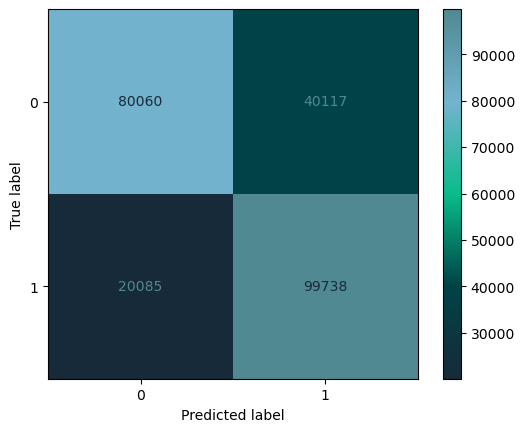

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_lgb_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lgb_model.classes_)
disp.plot(cmap=cmap, values_format='d')  # Use the custom colormap here
plt.savefig('confusion_matrix.png')
plt.show()


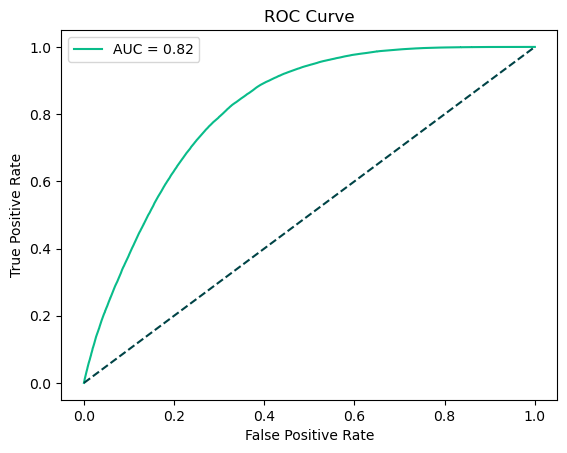

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = best_lgb_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color=colors[2])
plt.plot([0, 1], [0, 1], linestyle='--', color=colors[1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('ROC_Curve.png')
plt.show()


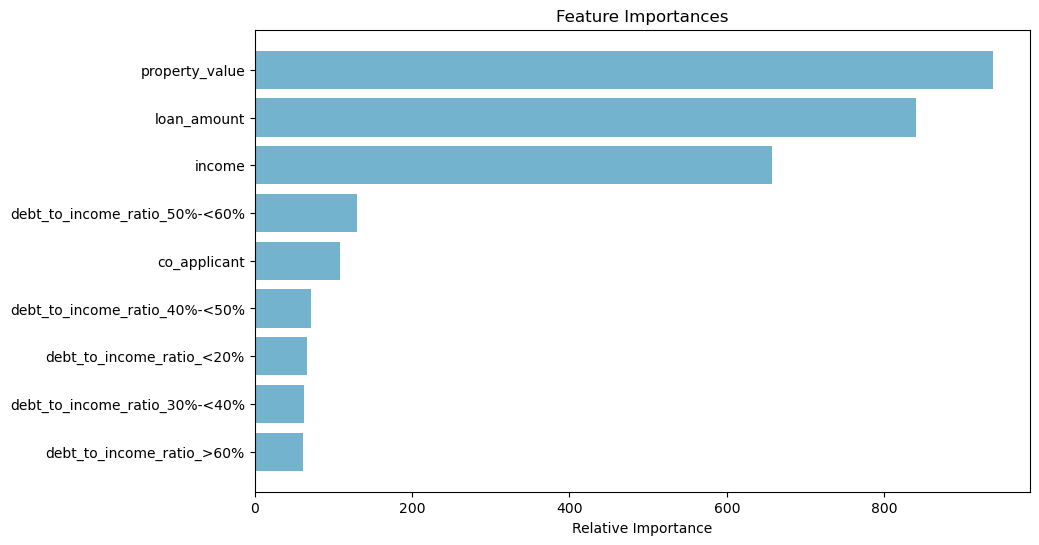

In [36]:
import numpy as np

importances = best_lgb_model.feature_importances_
features = X_test_scaled.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center', color=colors[3])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


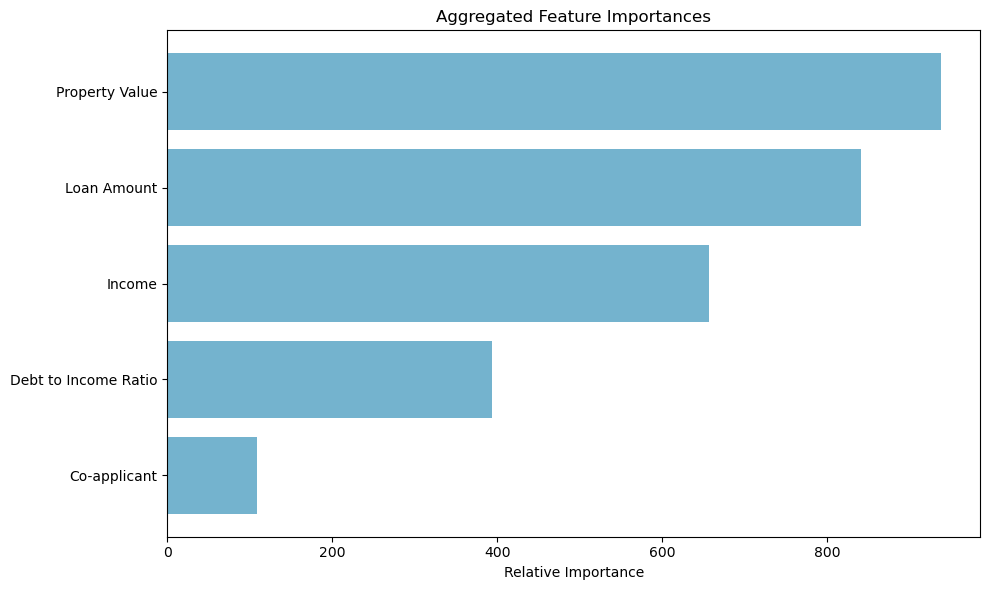

In [37]:
# Assuming `best_lgb_model` is your trained model
importances = best_lgb_model.feature_importances_

# Mapping original features to aggregated groups
feature_groups = {
    'Income': ['income'],
    'Property Value': ['property_value'],
    'Loan Amount': ['loan_amount'],
    'Co-applicant': ['co_applicant'],
    'Debt to Income Ratio': [
        'debt_to_income_ratio_50%-<60%', 
        'debt_to_income_ratio_>60%', 
        'debt_to_income_ratio_40%-<50%', 
        'debt_to_income_ratio_30%-<40%', 
        'debt_to_income_ratio_<20%'
    ]
}

# Aggregating feature importances
aggregated_importances = {group: 0 for group in feature_groups}
for group, features in feature_groups.items():
    for feature in features:
        if feature in X_test_scaled.columns:
            aggregated_importances[group] += importances[X_test_scaled.columns.get_loc(feature)]

# Plotting the aggregated feature importances
aggregated_importances_sorted = sorted(aggregated_importances.items(), key=lambda item: item[1], reverse=True)
groups, scores = zip(*aggregated_importances_sorted)

plt.figure(figsize=(10, 6))
plt.barh(groups, scores, color=colors[3])
plt.xlabel('Relative Importance')
plt.title('Aggregated Feature Importances')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.tight_layout()
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


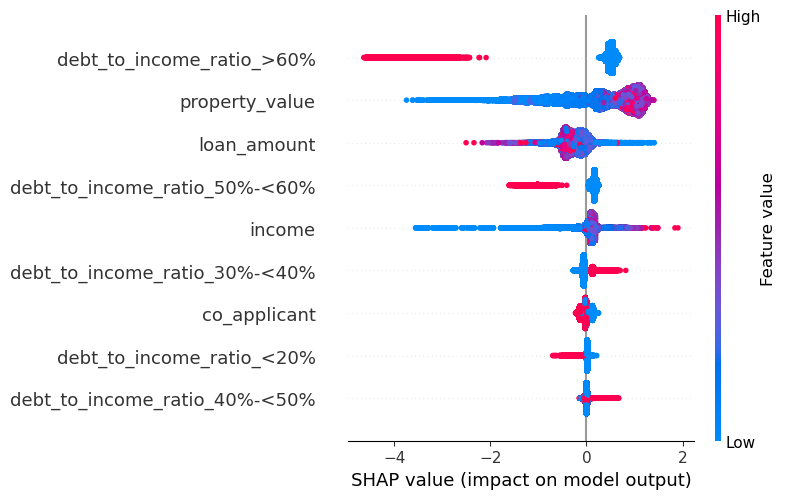

In [38]:
import shap

explainer = shap.TreeExplainer(best_lgb_model)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, color=custom_palette.as_hex())


In [39]:
# Save the model
filename = 'best_lgb_model.pkl'

# Save the model to disk
with open(filename, 'wb') as file:
    pickle.dump(best_lgb_model, file)

print(f"Model saved to {filename}")


Model saved to best_lgb_model.pkl
